Epoch 1/50
967/967 - 17s - 17ms/step - loss: 0.1850 - mae: 0.1729 - mse: 0.1455 - val_loss: 0.0132 - val_mae: 0.0023 - val_mse: 9.4940e-06 - learning_rate: 1.0000e-03
Epoch 2/50
967/967 - 20s - 21ms/step - loss: 0.0122 - mae: 0.0026 - mse: 1.4462e-05 - val_loss: 0.0100 - val_mae: 0.0017 - val_mse: 6.8602e-06 - learning_rate: 1.0000e-03
Epoch 3/50
967/967 - 20s - 21ms/step - loss: 0.0098 - mae: 0.0026 - mse: 1.4498e-05 - val_loss: 0.0079 - val_mae: 0.0017 - val_mse: 6.9727e-06 - learning_rate: 1.0000e-03
Epoch 4/50
967/967 - 20s - 21ms/step - loss: 0.0078 - mae: 0.0025 - mse: 1.3642e-05 - val_loss: 0.0065 - val_mae: 0.0020 - val_mse: 7.9297e-06 - learning_rate: 1.0000e-03
Epoch 5/50
967/967 - 21s - 21ms/step - loss: 0.0062 - mae: 0.0025 - mse: 1.3621e-05 - val_loss: 0.0046 - val_mae: 0.0015 - val_mse: 6.1058e-06 - learning_rate: 1.0000e-03
Epoch 6/50
967/967 - 12s - 12ms/step - loss: 0.0049 - mae: 0.0024 - mse: 1.3260e-05 - val_loss: 0.0037 - val_mae: 0.0018 - val_mse: 7.2234e-06 - lear

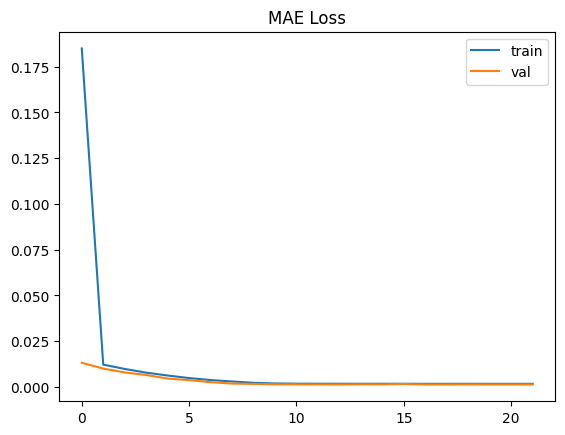

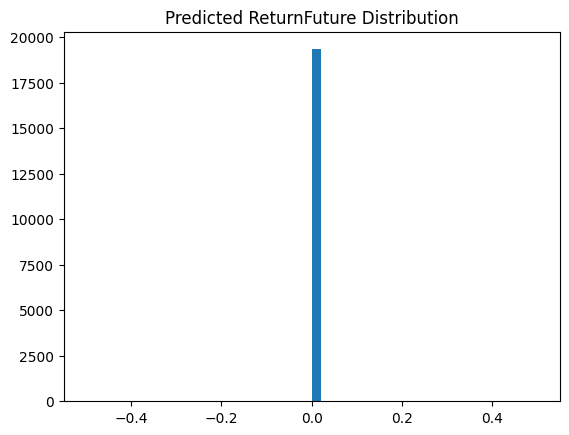

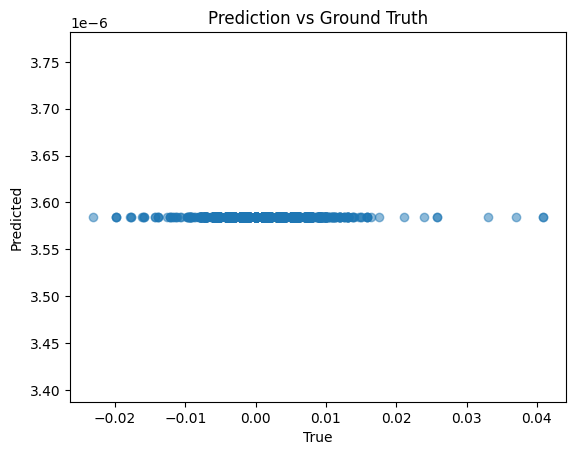

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, balanced_accuracy_score, f1_score, roc_curve
)
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.utils import class_weight
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    GRU, Dense, Dropout, BatchNormalization, Input, Layer
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
)
import tensorflow.keras.backend as K
import joblib

# === Attention Layer ===
class AttentionBlock(Layer):
    def __init__(self, d_model):
        super(AttentionBlock, self).__init__()
        self.query_dense = tf.keras.layers.Dense(d_model)
        self.key_dense = tf.keras.layers.Dense(d_model)
        self.value_dense = tf.keras.layers.Dense(d_model)
        self.attention = tf.keras.layers.Attention()

    def call(self, inputs):
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        return self.attention([query, key, value])

# === 0. Focal Loss tuned ===
def focal_loss(gamma=2., alpha=0.25):
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        ce = - (y_true * K.log(y_pred) + (1 - y_true) * K.log(1 - y_pred))
        w = alpha * y_true * K.pow(1 - y_pred, gamma) + \
            (1 - alpha) * (1 - y_true) * K.pow(y_pred, gamma)
        return K.mean(w * ce)
    return loss

# === 1. Load & Feature Engineering ===
df = pd.read_csv('/content/FPT.csv', parse_dates=['Date/Time'])
for c in ['Ticker','Open Interest']:
    if c in df: df.drop(c,axis=1,inplace=True)
WINDOW=30
FUTURE_OFFSET = 5  # số bước thời gian sau để dự đoán biến động

# Thêm các đặc trưng kỹ thuật
df['Return'] = df['Close'].pct_change()
df['MA_5'] = df['Close'].rolling(5).mean()
df['EMA_5'] = df['Close'].ewm(span=5,adjust=False).mean()
delta = df['Close'].diff()
gain = delta.clip(lower=0).rolling(14).mean()
loss = -delta.clip(upper=0).rolling(14).mean()
rs = gain/loss
df['RSI'] = 100 - 100/(1+rs)
df['BB_up'] = df['Close'].rolling(20).mean() + 2*df['Close'].rolling(20).std()
df['BB_dn'] = df['Close'].rolling(20).mean() - 2*df['Close'].rolling(20).std()
df['Momentum'] = df['Close'] - df['Close'].shift(10)

df['Future'] = df['Close'].shift(-FUTURE_OFFSET)
df['ReturnFuture'] = (df['Future'] - df['Close']) / df['Close']
df.dropna(inplace=True)
feat=[col for col in df.columns if col not in ['Date/Time','Future','ReturnFuture']]

# === 2. Scale & Window ===
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df[feat])
y = df['ReturnFuture'].values  
X, Y = [], []
for i in range(len(X_scaled)-WINDOW):
    X.append(X_scaled[i:i+WINDOW])
    Y.append(y[i+WINDOW])
X = np.array(X); Y = np.array(Y)

# === 3. Split ===
X_tr,X_te,Y_tr,Y_te = train_test_split(X,Y,test_size=0.2,shuffle=False)

# === 4. Build & Train GRU with Attention for Regression ===
input_layer = Input(shape=(WINDOW, X.shape[2]))
x = GRU(64, return_sequences=True, kernel_regularizer=l2(1e-4))(input_layer)
x = BatchNormalization()(x); x = Dropout(0.4)(x)
x = AttentionBlock(d_model=64)(x)
x = GRU(32, kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x); x = Dropout(0.4)(x)
x = Dense(32, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x); x = Dropout(0.3)(x)
output_layer = Dense(1)(x)  
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='mae',  # Mean Absolute Error
    metrics=['mae','mse']
)
es=EarlyStopping('val_loss',patience=5,restore_best_weights=True)
mc=ModelCheckpoint('best_regressor.keras','val_loss',mode='min',save_best_only=True)
rl=ReduceLROnPlateau('val_loss',factor=0.5,patience=3,min_lr=1e-5)

history=model.fit(
    X_tr,Y_tr,validation_split=0.2,
    epochs=50,batch_size=64,
    callbacks=[es,mc,rl],verbose=2
)

plt.figure(); plt.plot(history.history['loss'],label='train'); plt.plot(history.history['val_loss'],label='val'); plt.legend(); plt.title('MAE Loss')

# === 5. Evaluate Regression ===
y_pred=model.predict(X_te).ravel()
plt.figure(); plt.hist(y_pred,bins=50); plt.title('Predicted ReturnFuture Distribution')
plt.figure(); plt.scatter(Y_te, y_pred, alpha=0.5); plt.xlabel("True"); plt.ylabel("Predicted"); plt.title("Prediction vs Ground Truth")

mae = np.mean(np.abs(Y_te - y_pred))
mse = np.mean((Y_te - y_pred)**2)
print('MAE:', mae)
print('MSE:', mse)

# === 6. Save ===
model.save('regression_model.keras'); joblib.dump(scaler,'scaler.pkl')
print('Done')
